In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely import speedups
import matplotlib.pyplot as plt
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims
#from syspy.assignment.raw import fast_assign as assign # erronous
#from syspy.assignment.raw import assign # erronous
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
try:
    sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
except FileNotFoundError:
    sm = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_pt_network_agg')

In [7]:
# Load road links either from network path or from the
# equilibrium assignment path
if scenario.endswith('equilibrium'):
    road = stepmodel.read_json(model_path + 'de_road_network')
else:
    road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [8]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [9]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
if 'exo' in volumes_file:
    # Rename columns from VP2030 to match the model's demand segments
    car_segment_dict = {'0': '_no_car', '1': '_car'}
    vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                       'Fz4': 'business', 'Fz6': 'leisure'}
    sm.volumes = v.volumes.rename(columns={
        c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
        for c in v.volumes.columns if c.startswith('Fz')
    })
    # Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
    accompany_no_car_share = 101 / 1530
    accompany_car_share = 5569 / 30292
    sm.volumes['accompany'+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
    sm.volumes['accompany'+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)
else:
    sm.volumes = v.volumes

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it]


In [10]:
# Number of OD pairs in volumes table
len(set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])]))

4930600

In [11]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_zippedpickles(model_path + 'de_road_los')
pt = stepmodel.read_zippedpickles(model_path + 'de_pt_los')

pt_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.86s/it]


In [12]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if '(' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [13]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [14]:
sm.pt_los.sample()

,level_0,index,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
3384751,3384751,3418465,DE264_0,DE129_0,"(bus, coach)","(bus_378240, bus_385325, bus_385326, bus_53588...",5.0,208457,1201,343.0,...,0.116542,0.009494,0.431575,0.247049,0.410452,0.008269,0.251339,0.0356,0.0397,0.004048


In [15]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [16]:
# Number of OD pairs in LoS table
len(set([(o,d) for o,d in zip(sm.los['origin'], sm.los['destination'])]))

4944165

## Assignment

The current volumes table contains outward and return trips per OD pair.

In [17]:
# Assign volumes to LoS path table
sm.los.drop(sm.segments + [c for c in sm.los.columns
                           if 'utility' in c],
            axis=1, inplace=True, errors='ignore')
sm.volumes.drop('index', axis=1, inplace=True, errors='ignore')
sm.compute_los_volume(keep_segments=True)
# Save results in the respective table
car_modes = [t for t in sm.los['route_type'].unique() if 'car' in t]
sm.pt_los = sm.los.loc[~sm.los['route_type'].isin(car_modes)]
sm.car_los = sm.los.loc[sm.los['route_type'].isin(car_modes)]

In [18]:
# Create a column for car volumes
# Required for equilibrium assignment
merge_cols = ['origin', 'destination']
vols = pd.DataFrame(index=sm.volumes.index)
for seg in sm.segments:
    merged = sm.volumes[merge_cols+[seg]].merge(
        sm.car_los[merge_cols+[(seg, 'probability')]],
        on=merge_cols,
        how='left')
    vols[seg] = (merged[seg] * merged[(seg, 'probability')]).fillna(0)
sm.volumes['volume_car'] = vols[sm.segments].sum(axis=1)

In [19]:
# Assign volumes to network by segment
# Using quetzal high-level functions:
#sm.step_assignment(road=True, segmented=True, compute_los_volume=False)
# Or
#sm.segmented_car_assignment()
#sm.segmented_pt_assignment(on_road_links=False, path_column='link_path')#, split_by='route_type')
# Or core functions:
'''for segment in tqdm(sm.segments):
    column = 'link_path'
    l = sm.los.dropna(subset=[column])
    sm.links[segment] = assign(l[segment], l[column]).fillna(0)
    sm.road_links[segment] = assign(l[segment], l[column]).fillna(0)'''
# Note: end of 2022, quetzal's assignment functions were erronous
# Usevectorised pandas functions which are way faster
for seg in tqdm(sm.segments):
    sm.links[seg] = sm.pt_los[['link_path', seg]].explode('link_path')\
                    .groupby('link_path').sum()[seg]
    sm.links[seg] = sm.links[seg].fillna(0).astype(int)
    sm.road_links[seg] = sm.car_los[['link_path', seg]].explode('link_path')\
                         .groupby('link_path').sum()[seg]
    sm.road_links[seg] = sm.road_links[seg].fillna(0).astype(int)
sm.links['volume'] = sm.links[sm.segments].sum(axis=1)
sm.road_links['volume'] = sm.road_links[sm.segments].sum(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:15:17<00:00, 376.47s/it]


## Results

In [21]:
# Share of links with volumes assigned
len(sm.road_links.loc[sm.road_links['volume']>0]) / len(sm.road_links)

0.3106728355686629

In [20]:
# Show pkm (mio.) by disaggregated PT modes
if not 'length' in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
print('Network pkm for PT modes (million)')
print(sm.links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6)

,pkm
route_type,
air,337.056198
bus,13538.143194
coach,3782.675204
rail_long,11748.672915
rail_short,45653.896520


In [22]:
sm.road_links['pkm'] = sm.road_links['volume'] * sm.road_links['length'] / 1000
print('Aggregated pkm of cars (billion): {}'.format(
    (sm.road_links['pkm']).sum() / 1e9))

664.160144009448

In [23]:
print('Annual mileage of the average car: {}'.format(
    (sm.road_links['pkm']).sum() / 1.5 / params['vehicles']['car']))

9633.869647436697

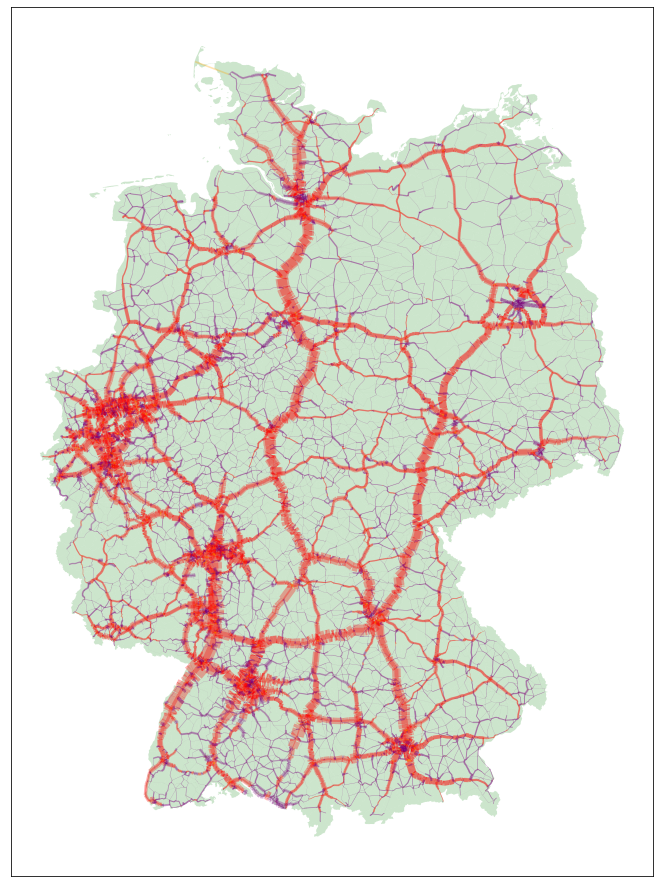

In [24]:
# Plot road assignment
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.zones = gpd.GeoDataFrame(sm.zones)
scaler = sm.road_links['volume'].max() / 35
mask = sm.road_links['volume']>1
colors = sm.road_links.loc[mask, 'highway'].map({
    'motorway': 'red', 'trunk': 'red', 'primary': 'purple', 'secondary': 'purple'
}).fillna('orange')
sm.road_links.loc[mask, ['geometry']].plot(
    alpha=.3,
    color=list(colors),
    linewidth=list(sm.road_links.loc[mask, 'volume']/scaler),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_road.png', dpi=400)

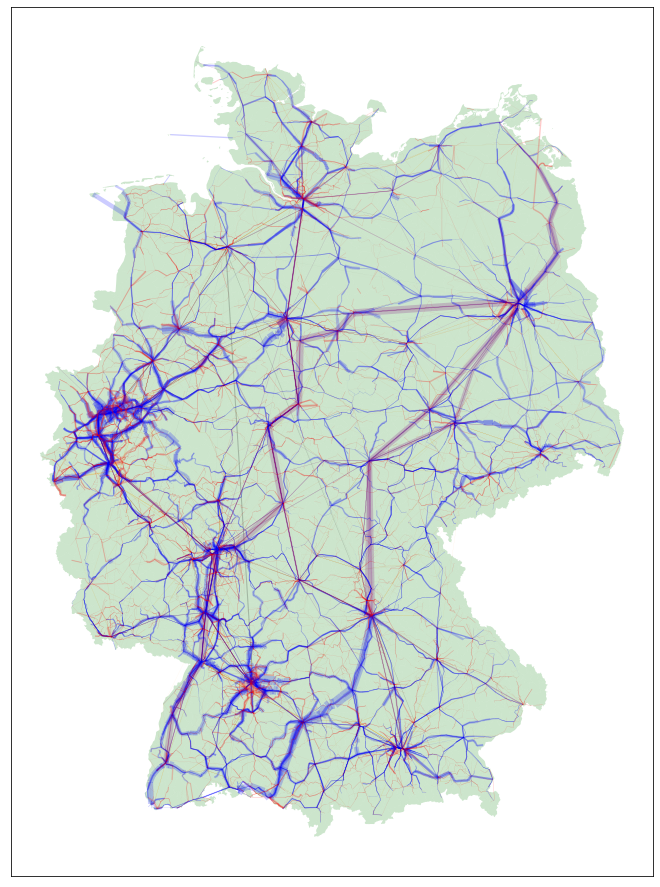

In [25]:
# Only PT
sm.links = gpd.GeoDataFrame(sm.links)
mask = sm.links['volume']>1
colors = sm.links.loc[mask, 'route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.links.loc[mask, ['geometry']].plot(
    alpha=.2,
    color=list(colors),
    linewidth=list(sm.links.loc[mask,'volume'] / sm.links.loc[mask,'volume'].max() * 25),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=400)

In [ ]:
# Map road volumes to NUTS zones
road_geo = gpd.GeoDataFrame({'NUTS3': np.nan},
                            index=sm.road_links.index,
                            geometry=[shapely.geometry.Point(g.coords[0])
                                      for g in sm.road_links['geometry']],
                            crs=sm.epsg)
# Map
shapely.speedups.enable()
zones = sm.zones.groupby('NUTS_ID')['geometry'].apply(lambda g: g.unary_union)
for zone, geo in tqdm(zones.items(), total=len(zones)):
    road_geo.loc[road_geo['geometry'].within(geo), 'NUTS3'] = zone
sm.road_links['NUTS3'] = road_geo['NUTS3']

In [26]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [27]:
od_sum.sample()

,,segment,commuting,business,education,buy/execute,leisure,accompany,root
,,sum,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,
DE719_3,DEA43_4,rail_long,6.473661e-97,0.000056,1.098551e-210,0.003896,0.181052,0.000138,0.185142


In [28]:
# Add averages from following attributes
attrs = ['time', # hours per trip
         'in_vehicle_time', # seconds per ride
         #'waiting_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
def weighted_average(data, data_col, weight_col, by_col):
    data['_data_times_weight'] = data[data_col] * data[weight_col]
    data['_weight_where_notnull'] = data[weight_col] * pd.notnull(data[data_col])
    g = data.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del data['_data_times_weight'], data['_weight_where_notnull']
    return result
for attr in attrs:
    od_sum[('root', attr)] = weighted_average(
        sm.los.loc[sm.los['volume']>1],
        attr, 'volume', ['origin', 'destination', 'route_type']
    )
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600
#od_sum[('root', 'waiting_time')] /= 3600
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [29]:
# Load calibration dataset for modal split validation
mid_val = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid_val.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid_val['mode_agg'] = [mode_dict_mid[i] for i in mid_val.index]

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='business'>,
       <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='buy/execute'>, <AxesSubplot:ylabel='leisure'>,
       <AxesSubplot:ylabel='accompany'>], dtype=object)

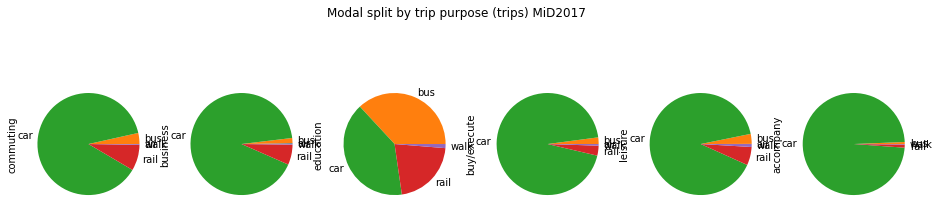

In [30]:
mid_val.groupby('mode_agg').sum()[purposes].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

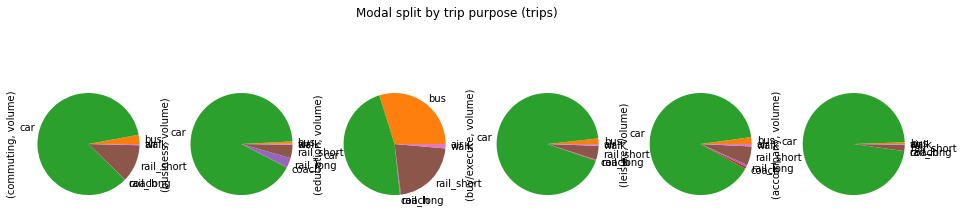

In [31]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [32]:
# MiD mode shares in percent
(mid_val.groupby('mode_agg').sum() /
 mid_val[purposes].sum() * 100)[purposes].round(2)

,commuting,business,education,buy/execute,leisure,accompany
mode_agg,,,,,,
air,0.00,0.26,0.00,0.01,0.05,0.00
bus,3.49,1.64,36.90,2.09,3.15,0.64
car,88.03,91.52,40.39,94.24,90.08,98.22
rail,8.22,6.38,21.42,3.14,5.79,0.98
walk,0.26,0.20,1.29,0.53,0.93,0.16


In [33]:
print('Model mode shares in percent')
print((od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
       od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2))

Model mode shares in percent
segment    commuting business education buy/execute leisure accompany
sum           volume   volume    volume      volume  volume    volume
mode                                                                 
air             0.00     0.09      0.00        0.00    0.01      0.00
bus             2.92     0.74     29.85        1.78    2.16      0.55
car            84.71    91.54     46.80       92.87   89.75     97.20
coach           0.01     0.09      0.09        0.19    0.73      0.03
rail_long       0.07     3.11      0.26        0.17    0.60      0.01
rail_short     11.90     4.19     21.62        4.40    5.98      2.00
walk            0.39     0.25      1.38        0.58    0.77      0.21


In [34]:
# MiD2017 mode shares - total
mid_val['sum'] = mid_val[purposes].sum(axis=1)
(mid_val.groupby('mode_agg').agg({'sum': 'sum'}) / mid_val['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.03
bus,4.12
car,89.24
rail,6.03
walk,0.57


In [35]:
print('Model mode shares in percent - total')
print((od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2))

Model mode shares in percent - total
sum         volume   time  in_vehicle_time  length  ntransfers    pkm
mode                                                                 
air           0.00   6.32             4.89    8.56       10.64   0.07
bus           3.36   0.39             0.21    0.10        0.99   1.42
car          87.81  24.52            32.09   34.61        0.00  89.61
coach         0.26  29.11            25.74   18.26       35.77   0.72
rail_long     0.32  27.98            26.90   30.00       34.00   1.96
rail_short    7.68  11.64            10.17    8.46       18.60   6.03
walk          0.57   0.03             0.00    0.01        0.00   0.19


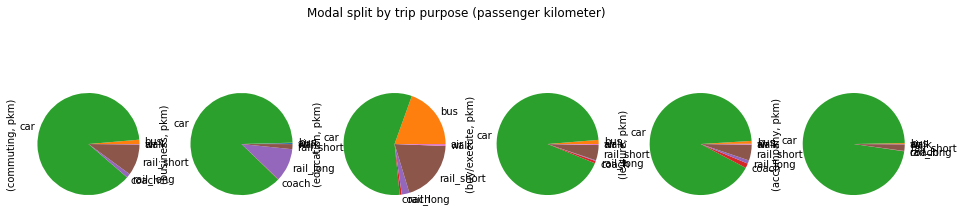

In [36]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [37]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
#island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
#sm.car_los['o'] = sm.car_los['origin'].replace(island_dict).str[:5]
#sm.car_los['d'] = sm.car_los['destination'].replace(island_dict).str[:5]
#distances_agg = sm.car_los.groupby(['o', 'd']).agg({'length': 'mean'}) / 1000
#distances_agg.index.set_names(['origin', 'destination'], inplace=True)
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [38]:
# Cut matrices into distance classes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od['bins'] = pd.cut(od.merge(distances, how='left',
                             left_on=['origin', 'destination'],
                             right_index=True)['length'],
                    bins=bins, labels=labels)
if not 'rail' in od.columns.get_level_values(1):
    for p in purposes:
        od[(p, 'rail')] = od[(p, 'rail_short')] + od[(p, 'rail_long')]
        od[(p, 'bus')] = od[(p, 'bus')] + od[(p, 'coach')]
if not 'car' in od.columns.get_level_values(1):
    for p in purposes:
        od[(p, 'car')] = od[(p, 'private_car')] + od[(p, 'car_sharing')]
od_binned = od.groupby('bins').sum()

In [39]:
# Load the calibration dataset for validation
mid_available = True
try:
    mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
    # Replace LAU codes with NUTS IDs
    assert str(mid2017.loc[0, 'origin']).startswith('DE')
    # Rename modes and purposes
    mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
    mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
    # Count observations by distance class
    mid2017['length'] = mid2017.set_index(['origin', 'destination']
                                         ).index.map(distances.to_dict()['length'])
    mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
    mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
        ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)
    # Normalise and scale the dataset
    mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
    mid2017 = mid2017 * (od_binned.mean().mean()
                         / mid2017.mean().mean())
except FileNotFoundError:
    mid_available = False
    print('Validation plots with detailed MiD2017 data are not possible because the dataset is missing')
except AssertionError:
    mid_available = False
    print('MiD2017 data for validation of the model results could not be loaded '
          + 'for one of the following reasons: '
          + 'You don not have access to the dataset; '
          + 'you have not run the cal10 and cal11 notebook, which prepares data for validation; '
          + 'you were not able to run cal11 because your computer does not provide enough RAM '
          + 'to run the model without sparsification. Proceeding without validation plots.')

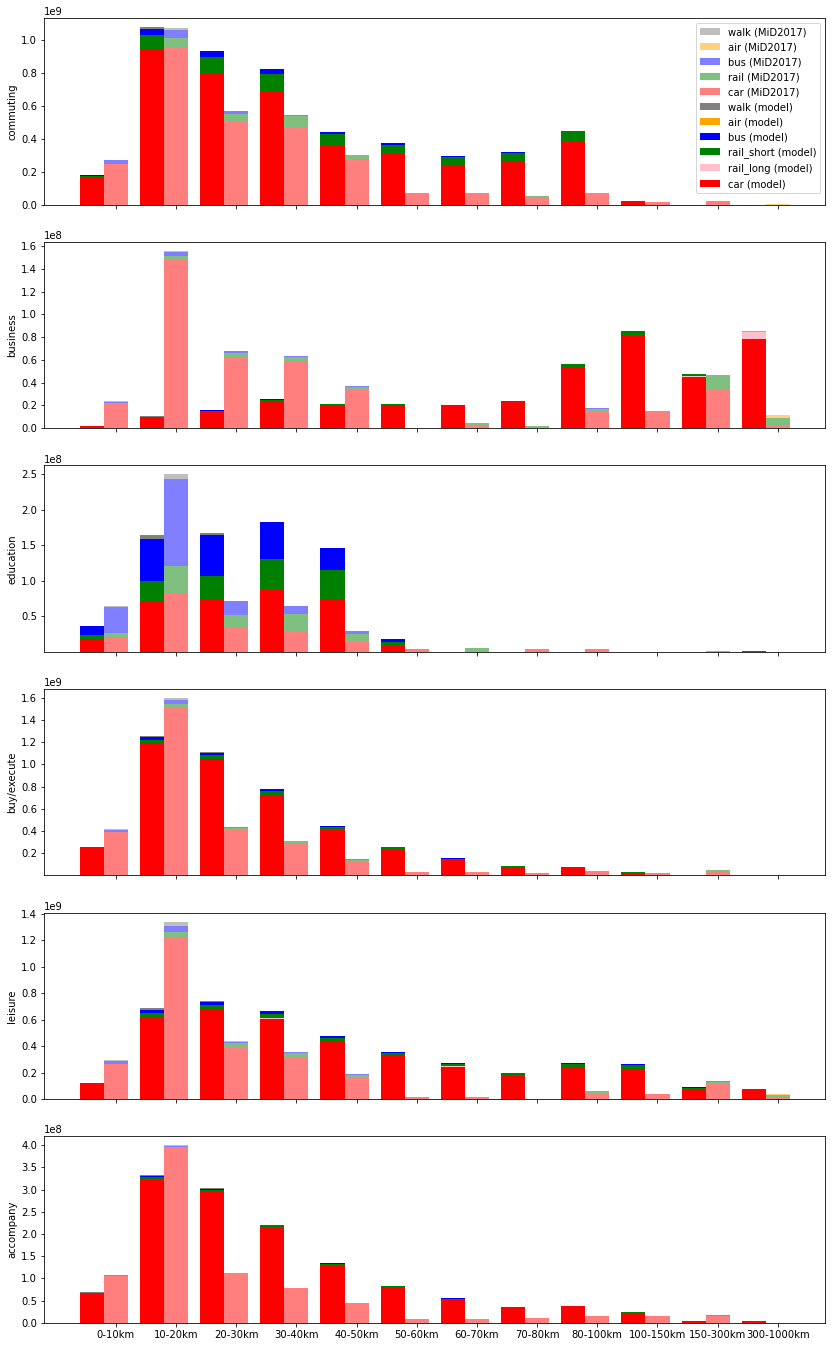

In [40]:
# Plot distance and mode distribution by segment
if mid_available:
    fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                           figsize=(14,len(purposes)*4),
                           sharex='all', sharey='row')
    modes_model = car_modes + ['rail_long', 'rail_short', 'bus', 'air', 'walk']
    modes_mid = ['car', 'rail', 'bus', 'air', 'walk']
    colors_model = ['red', 'indianred'][:len(car_modes)] + ['darkgreen', 'green', 'blue', 'orange', 'grey']
    colors_mid = ['red', 'green', 'blue', 'orange', 'grey']
    width = 0.4
    ind = np.arange(len(labels))
    for seg in range(len(purposes)):
        model_vols = [od_binned[(purposes[seg], mode)] for mode in modes_model]
        mid_vols = [mid2017[(purposes[seg], mode)]
                    if (purposes[seg], mode) in mid2017.columns
                    else pd.Series(index=mid2017.index, data=0, name=(purposes[seg], mode))
                    for mode in modes_mid]
        for i in range(len(modes_model)):
            model_bottom = 0 if i==0 else sum(model_vols[:i])
            ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                        width=width, tick_label=labels, color=colors_model[i],
                        label=modes_model[i]+' (model)')
        for i in range(len(modes_mid)):
            mid_bottom = 0 if i==0 else sum(mid_vols[:i])
            ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                        width=width, tick_label=labels, color=colors_mid[i],
                        label=modes_mid[i]+' (MiD2017)')
        ax[seg].set_ylabel(purposes[seg])
    h, l = ax[0].get_legend_handles_labels()
    ax[0].legend(h[::-1], l[::-1])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=400)

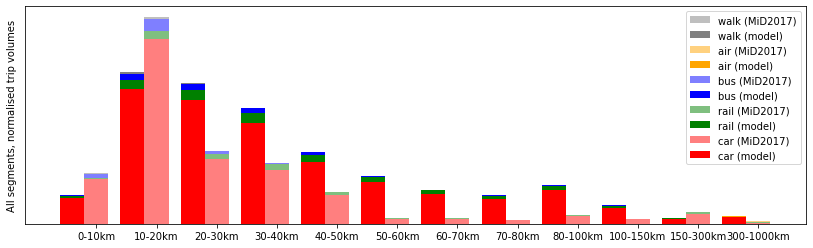

In [41]:
# Plot distance and mode distribution all together
if mid_available:
    try:
        fig, ax = plt.subplots(figsize=(14,4))
        modes = ['car', 'rail', 'bus', 'air', 'walk']
        colors = ['red', 'green', 'blue', 'orange', 'grey']
        width = 0.4
        model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
        mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
        for i in range(len(modes)):
            if i==0:
                model_bottom = 0
                mid_bottom = 0
            else:
                model_bottom = sum(model_vols[:i])
                mid_bottom = sum(mid_vols[:i])
            ax.bar(ind, model_vols[i], bottom=model_bottom,
                   width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
            ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
                   width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
        ax.set_ylabel('All segments, normalised trip volumes')
        ax.set_yticks([])
        h, l = ax.get_legend_handles_labels()
        ax.legend(h[::-1], l[::-1])
        plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=400)
    except:
        pass

In [42]:
# Function to plot a traffic map
def plot_traffic(ax):
    pt_mask = (sm.links['volume'].notna()) & (sm.links['volume']>1)
    road_mask = (sm.road_links['volume'].notna()) & (sm.road_links['volume']>1)
    scaler = max(sm.links['volume'].max(), sm.road_links['volume'].max()) / 50
    sm.links.loc[pt_mask, ['geometry']].plot(
        alpha=.5, color=blue, linewidth=list(sm.links.loc[pt_mask, 'volume']/scaler*2),
        ax=sm.road_links.loc[road_mask, ['geometry']].plot(
            alpha=.3, color='red',
            linewidth=list(sm.road_links.loc[road_mask, 'volume']/scaler),
            ax=sm.zones.plot(alpha=.2, color='green', ax=ax)))

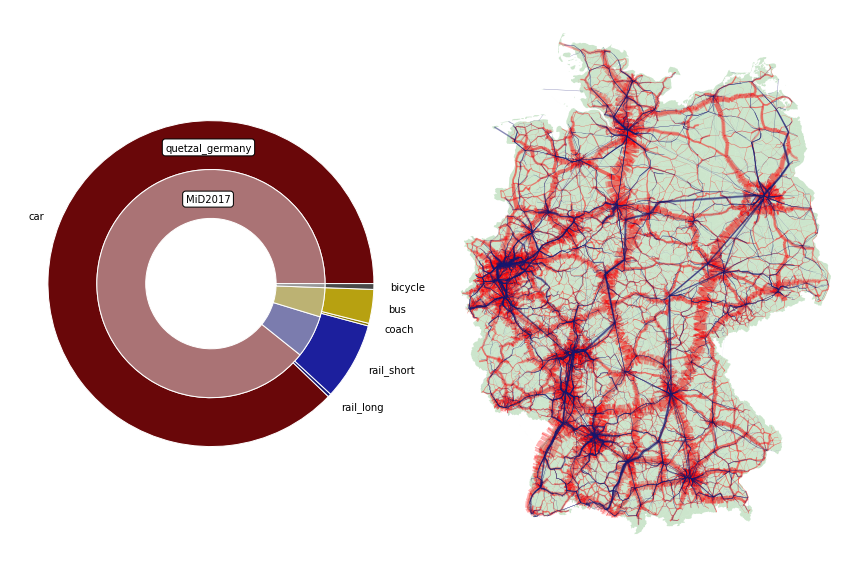

In [43]:
# Figure for publication: https://rdcu.be/c1yx6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
red = '#690709'
red2 = 'indianred'
blue = '#151770'
blue2 = '#1C1F9D'
grey = '#494949'
yellow = '#887706'
yellow2 = '#B7A111'
light = '#bdbdbd'
red_ = '#6907098F'
blue_ = '#1517708F'
grey_ = '#4949498F'
yellow_ = '#8877068F'
light_ = '#bdbdbd8F'

# double ring: Mode split model vs. MiD2017
ax[0].axis('equal')
width = 0.3
model_values = od_sum[('root', 'volume')].groupby(level=2).sum().loc[
    car_modes + ['rail_long', 'rail_short', 'coach', 'bus', 'walk']
].rename(index={'walk': 'bicycle'})
pie, _ = ax[0].pie(model_values, labels=model_values.index,
                   radius=1,
                   colors=[red, red2][:len(car_modes)] + [blue, blue2, yellow, yellow2, grey])
plt.setp( pie, width=width, edgecolor='white')
ax[0].annotate(
    'quetzal_germany', xy=(-0.28, .82),
    bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
)
mid_values = mid_val.groupby('mode_agg').sum()[purposes].sum(axis=1).loc[
    ['car', 'rail', 'bus', 'walk']]
pie2, _ = ax[0].pie(mid_values,# labels=mid_values.index,
                    radius=1-width, labeldistance=0.7,
                    colors=[red_, blue_, yellow_, grey_])
plt.setp( pie2, width=width, edgecolor='white')
ax[0].annotate(
    'MiD2017', xy=(-0.155, .5),
    bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
)

plot_traffic(ax[1])
ax[1].axis('off')
fig.tight_layout()
plt.savefig(output_path + scenario + '/' + 'validation_mode_shares_traffic.png', dpi=400)

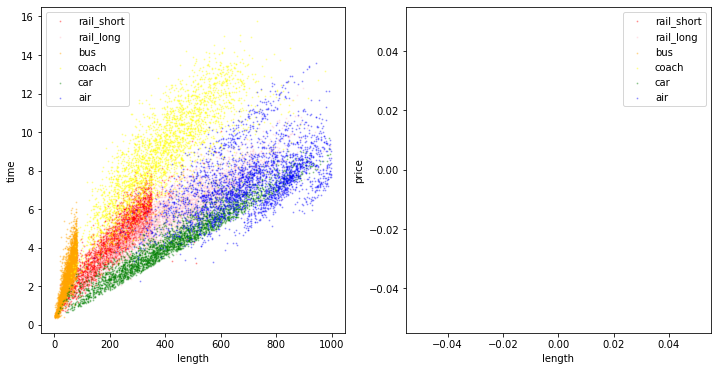

In [44]:
# How do the LoS attributes look like again?
if manual:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    c_dict = {'rail_short': 'red', 'rail_long': 'pink', 'bus': 'orange',
              'coach': 'yellow', 'car': 'green', 'air': 'blue'}
    sm.los['length'] = sm.los['length'] / 1000
    if not 'price' in sm.los.columns:
        sm.los['price'] = sm.los[[c for c in sm.los.columns if 'price' in c]].mean()
    for m in c_dict.keys():
        size = min(3000, len(sm.los.loc[sm.los['route_type']==m]))
        sm.los.loc[sm.los['route_type']==m].sample(size).plot(
            ax=ax[0], kind='scatter', x='length', y='time', s=.9, c=c_dict[m], alpha=.3, label=m)
        sm.los.loc[sm.los['route_type']==m].sample(size).plot(
            ax=ax[1], kind='scatter', x='length', y='price', s=.9, c=c_dict[m], alpha=.3, label=m)
    plt.legend()
    plt.savefig(output_path + scenario + '/' + 'LoS_attributes.png', dpi=300)
    sm.los['length'] = sm.los['length'] * 1000

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [45]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [46]:
print('Aggregated modal split in million pkm by main mode')
print(od.groupby(level=2).sum()['pkm'] / 1e6)

mode
air              519.537289
bus            10517.134021
car           664160.758637
coach           5319.969808
rail_long      14549.793723
rail_short     44673.113142
walk            1389.428240
Name: pkm, dtype: float64

In [47]:
print('Aggregated pkm (billion): {}'.format(od.groupby(level=2).sum()['pkm'].sum() / 1e9))

741129.7348595158

In [48]:
print('Total volumes between model zones (billion): {}'.format(sm.los['volume'].sum()/1e9))

16081.92747981019

In [49]:
# Volumes between NUTS3-level (million)
sm.los.loc[sm.los['origin'].str[:5]!=sm.los['destination'].str[:5], 'volume'].sum() / 1e6

12479.885769556324

In [50]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [51]:
# Calculate weighted averages by zone aggregation
od['volume'] += 1e-9 # prevent weights being zero in sum
od_agg = od.groupby(['origin', 'destination', 'mode']).agg({'volume': 'sum'})
for attr in ['time', 'in_vehicle_time', 'length']:
    od_agg[attr] = weighted_average(
        od, attr, 'volume', ['origin', 'destination', 'mode']
    )

## Save model

In [52]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od_agg.to_excel(writer, sheet_name='od')

In [53]:
sm.to_zippedpickles(model_path + 'de_assignment',
                    only_attributes=['links', 'nodes', 'road_links', 'volumes'])

los: 100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [01:00<00:00,  3.77s/it]


In [54]:
# Save pkm from LoS table
od_sum['root'][['pkm']].to_csv(output_path + scenario + '/' + 'pkm_inter_main_mode.csv')
print('Total pkm by main mode (billion): {}'.format(np.round(od_sum['root']['pkm'].sum()/1e9), 2))

In [55]:
# Save pkm from networks
inter_car = sm.road_links.groupby('NUTS3').agg({"pkm": 'sum'})
sm.links['NUTS3'] = sm.links['a'].map(sm.nodes['FID'].str[:5])
inter_pt = sm.links.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'})
inter_car['route_type'] = 'car'
inter = pd.concat([inter_car.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'}), inter_pt])
inter.to_csv(output_path + scenario + '/' + 'pkm_inter_network.csv')
print('Total pkm on the networks (billion): {}'.format(np.round(inter['pkm'].sum()/1e9), 2))

In [ ]:
# Save pkm together with inner-zonal traffic
inner = pd.read_csv(output_path + scenario + '/inner_zone_pkm.csv', header=[0,1], index_col=0)
inner = inner.stack('mode').reset_index().replace({'rail': 'rail_short', 'non-motorised': 'walk'})
inner['origin'] = inner['origin'].str[:5] # NUTS3
inner = inner.groupby(['origin', 'mode']).sum().sum(axis=1)
inter.index.names = inner.index.names
all_pkm = pd.merge(inner.rename('pkm'), inter, how='outer',
                   left_index=True, right_index=True).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_x'] + all_pkm['pkm_y']
all_pkm[['pkm']].to_csv(output_path + scenario + '/pkm.csv')